1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [29]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter



C:\Users\walidmash\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


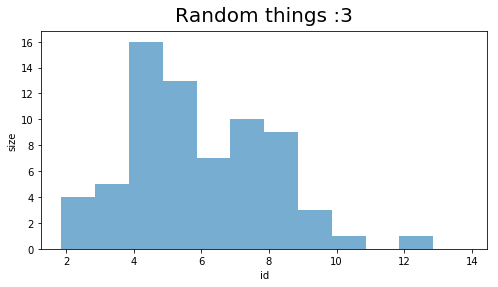

In [61]:
N = 70
x = np.random.gamma(6, size=N)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))
ax.hist(x, bins=np.arange(x.min(), x.max()), alpha=0.6)
ax.set_title("Random things :3", fontsize=20, verticalalignment='bottom')
ax.set_xlabel("id")
ax.set_ylabel("size")
fig.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

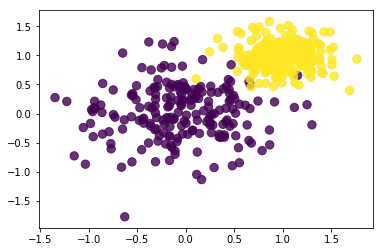

In [87]:
from IPython.display import Image
Image('../data/p.png')

(array([  7,  23,  66, 117, 213, 247, 185, 102,  33,   7], dtype=int64), array([-0.52335578, -0.4626629 , -0.40197001, -0.34127713, -0.28058424,
       -0.21989136, -0.15919847, -0.09850558, -0.0378127 ,  0.02288019,
        0.08357307]))
[-0.52335578 -0.4626629  -0.40197001 -0.34127713 -0.28058424 -0.21989136
 -0.15919847 -0.09850558 -0.0378127   0.02288019  0.08357307]


ValueError: x and y must be the same size

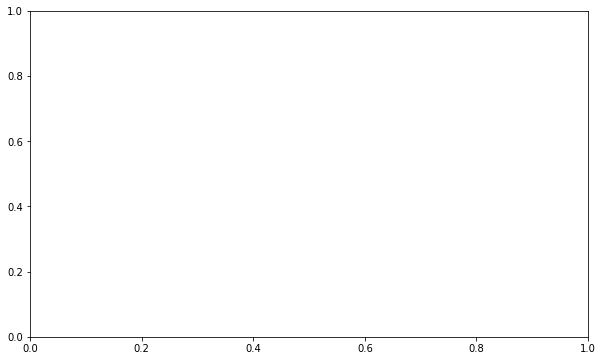

In [117]:
import scipy.stats as stats
x=np.linspace(-1.5,1.5,1000)
a, b = -1.5, 1.5
mu, sigma = -0.2, 0.1
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)

vals = dist.rvs(1000)
y,x= np.histogram(a=vals)
print(np.histogram(a=vals))
print(x)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=x,y=y, label='females')
# ax.scatter(x=yrs, y=y[0,:]+5, label='males')

ax.set_title('number of smokers in italy over time')
ax.legend(loc='upper left')
ax.set_ylabel('numbers in thousands')
ax.set_ylabel('year')
ax.set_xlim(-1.5,1.5)
fig.tight_layout()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot